# **XGBOOST**

**XGBoost** (eXtreme Gradient Boosting) is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements Machine Learning algorithms under the [Gradient Boosting](https://towardsdatascience.com/understanding-gradient-boosting-machines-9be756fe76ab) framework. XGBoost provides a parallel tree boosting that solve many data science problems in a fast and accurate way. 

* An open-source implementation of the *gradient boosted trees algorithm* 
* Supervised Learning algorithm (both, regression and classification tasks)

***Decision Trees:*** 
 sequence of simple decision rules that, combined, produce a prediction of the desired value.

***Gradient Boosting:*** 
ensemble method, meaning it's a way of combining predictions from several models into one. It does that by taking each predictor sequentially and modelling it based on its predecessor's error (giving more weight to predictors that perform better).  It is a specific type of boosting, called like that beacuse it minimises tha loss function usign a *gradient descent algorithm*




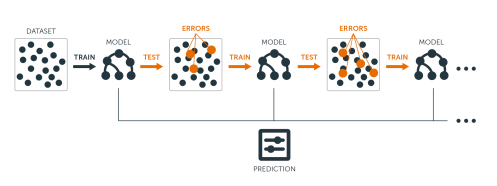

--> It is a gradient boosting algorithm that uses decision trees as its "weak" predictors. 

*Recommended:  [Documentation](https://xgboost.readthedocs.io/en/latest/)*

## **Some Hyperparameters:**

* **Booster:** the boosting algorithm, for which you have 3 options: gbtree, gblinear or dart . The default option is gbtree. dart is a similar version that uses dropout techniques to avoid overfitting, and gblinear uses generalized linear regression instead of decision trees.  

* **reg_alpha and reg_lambda:** reg_alpha and reg_lambda are L1 and L2 regularisation terms, respectively. The greater these numbers, the more conservative (less prone to overfitting but might miss relevant information) the model becomes. Recommended values lie between 0–1000 for both.

* **max_depth:** it sets the maximum depth of the decision trees. The greater this number, the less conservative the model becomes. If set to 0, then there is no limit for trees’ depth.

* **subsample:** subsample is the size of the sample ratio to be used when training the predictors. Default is 1, meaning there is no sampling and we use the whole data. If set to 0.7, for instance, then 70% of the observations would be randomly sampled to be used in each boosting iteration (a new sample is taken for each iteration). It can help to prevent overfitting.

* **num_estimators:** num_estimators sets the number of boosting rounds, which equals setting the number of boosted trees to use. The greater this number, the greater the risk of overfitting (but low numbers can also lead to low performance).

*See full [hyperparameters](https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst)*


Data implemented: 

* Functional Magnetic Resonance Imaging (BOLD signal)
* Automated Anatomical Labeling Atlas (116 regions)
* Functional connectivity method: Pearson Correlation Coefficients


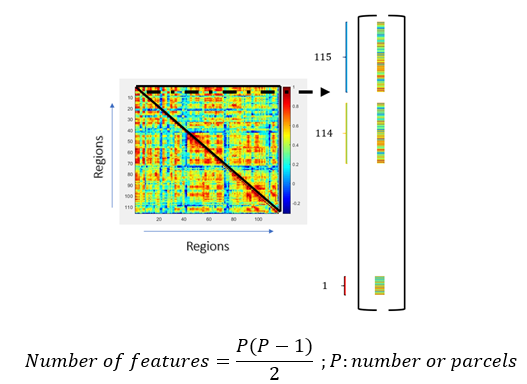/></center>



In [ ]:
#Mount google drive to access fMRI data 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Lib imports

In [ ]:
import multiprocessing

#Torch libs
import torch

#Plot libs
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns

#io libs
import pandas as pd
import numpy as np
import scipy.io as sio

#System libs
import os
import sys

#Classifier
from xgboost import XGBClassifier

#Sklearn libs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
#Data

dir_data='/content/drive/My Drive/CORR_MATS/BINARY_CLASS/FEATURE_EXTRACT/BINARYCLASS_N_MATCHED/'
    
corr = sio.loadmat(dir_data + 'diagnosis.mat')['matriz_AAL'].T
y = sio.loadmat(dir_data + 'diagnosis.mat')['Y_cc2'].T

Functions

In [ ]:
def AUCROC(model, xtest, ytest, xtrain, ytrain):
    '''It computes and plot the AUCROC curve.
       -Area Under Curve (AUC): it measures the two-dimensional area under the complete ROC curve. It represents the degree or measure of separability. The higher the AUC
       the better the model is at predicting 0s and 1s as 1s.
       -Receiver operating Characteristic (ROC): probability curve of the true positive rate against false positive rate (tradeoff between sensitivity and specificity)'''

    #Prediction
    y_pred_train = model.predict_proba(xtrain)[::,1]
    y_pred_proba = model.predict_proba(xtest)[::,1]

    #Metric calculation
    fpr, tpr, _ = metrics.roc_curve(ytest, y_pred_proba)
    fpr1, tpr1, _ = metrics.roc_curve(ytrain, y_pred_train)

    auc = metrics.roc_auc_score(ytest, y_pred_proba)
    auc1 = metrics.roc_auc_score(ytrain,y_pred_train)

    #Plot
    plt.plot(fpr1,tpr1, label = "train, auc=" + str(auc1))
    plt.title('AUCROC')
    plt.legend()
    
    plt.plot(fpr, tpr, label = "test, auc=" + str(auc))
    #plt.title('AUCROC')
    plt.legend(loc=4)
    plt.show()

    return 

In [ ]:
def cmap(y_test, y_pred):
    ''' It calculates and plot the confusion matrix.
        Confusion Matrix: describe the performance of a classfication model on a set of test data'''

    #Calculation of the confusion matrix
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    class_names = [0,1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))

    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    #Create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu", fmt = 'g')
    ax.xaxis.set_label_position('top')

    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    plt.show()

    return 

In [ ]:
def func_metrics(y_test, y_pred): 
  '''Calculates the performance of the model using specific metrics'''

  x=PrettyTable()
  
  x.add_column("Accuracy ", [metrics.accuracy_score(y_test, y_pred)])
  x.add_column("Precision ", [metrics.precision_score(y_test, y_pred)])
  x.add_column("Recall ", [metrics.recall_score(y_test, y_pred)])
  x.add_column("F1 ", [metrics.f1_score(y_test, y_pred)])

  return x

K-FOLD CROSS VALIDATION

In [ ]:
def K_Fold(X, y, n_splits): 

  model_sk = XGBClassifier(base_score = 0.5, booster = 'gbtree', colsample_bylevel = 1,
                      colsample_bynode = 1, colsample_bytree = 1, gamma = 0,
                      learning_rate = 0.1, max_delta_step = 0, max_depth = 4,
                      min_child_weight = 1, missing = None, n_estimators = 100, n_jobs = 1,
                      nthread = None, objective = 'binary:logistic', random_state = 0,
                      reg_alpha = 0, reg_lambda = 1, scale_pos_weight = 1, seed = None,
                      silent = None, subsample = 0.7, verbosity = 1)

  # create stratified kfold object split
  skf = StratifiedKFold(n_splits=n_splits)

  for train_ind, test_ind in skf.split(X,y):
        
      corr_train_inter = X[train_ind]
      corr_test = X[test_ind] 
      Y_train_inter = y[train_ind]
      Y_test = y[test_ind]
      
      model_sk.fit(corr_train_inter,Y_train_inter)
      y_hat = model_sk.predict(corr_test)

  scores = cross_val_score(model_sk, corr_train_inter, Y_train_inter, cv=n_splits) #Accuracy of each K-fold
  scores_mean = scores.mean()
  st_scores = scores.std()*2 

  return scores, scores_mean, st_scores

In [ ]:
def performance(model, X_test, y_test, X_train, y_train, y_pred, k_fold= False): 
  '''Postcondition: mets: metrics, AUCROC, CMAP, Kfold '''
  
  mets=func_metrics(y_test, y_pred)
  print(mets)
  print('\n')

  if k_fold: 
    scores, mean, std = K_Fold(corr, np.ravel(y), n_splits=5)
    z=PrettyTable()
    z.add_column("Scores ", [scores])
    z.add_column("Mean Accuracy",[mean])
    print(z)
    #print("Scores: ", scores) 
    #print("Accuracy1: %0.2f (+/-%0.2f)" %(mean, std)) #Accuracy of the complete model

  AUCROC(model, X_test, y_test, X_train, y_train)
  print('\n')
  cmap(y_test, y_hat)

  return 

Data Transformation and Feature Engineering

In [ ]:
'''In the next session I will talk about it'''

'In the next session I will talk about it'

Machine Learning Modeling and Hyperparameter Tunning

In [ ]:
#Split
seed=45
X_train, X_test, y_train, y_test = train_test_split(corr, np.ravel(y), test_size = 0.2, random_state = seed)

#Model generation
model = XGBClassifier(base_score = 0.5, booster = 'gbtree', colsample_bylevel = 1,
                      colsample_bynode = 1, colsample_bytree = 1, gamma = 0,
                      learning_rate = 0.1, max_delta_step = 0, max_depth = 4,
                      min_child_weight = 1, missing = None, n_estimators = 100, n_jobs = 1,
                      nthread = None, objective = 'binary:logistic', random_state = 0,
                      reg_alpha = 0, reg_lambda = 1, scale_pos_weight = 1, seed = None,
                      silent = None, subsample = 0.7, verbosity = 1)

#Training
model.fit(X_train, y_train)

#Testing
y_hat = model.predict(X_test)

Performance results

+--------------------+--------------------+--------------------+-------------------+
|     Accuracy       |     Precision      |      Recall        |        F1         |
+--------------------+--------------------+--------------------+-------------------+
| 0.5645161290322581 | 0.6666666666666666 | 0.4117647058823529 | 0.509090909090909 |
+--------------------+--------------------+--------------------+-------------------+


+----------------------------------------------------------+--------------------+
|                         Scores                           |   Mean Accuracy    |
+----------------------------------------------------------+--------------------+
| [0.58       0.56       0.6        0.6122449  0.57142857] | 0.5847346938775511 |
+----------------------------------------------------------+--------------------+


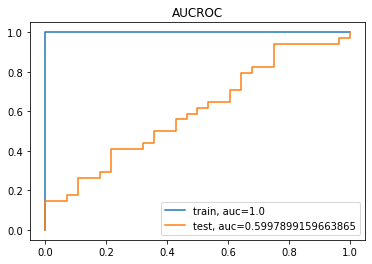

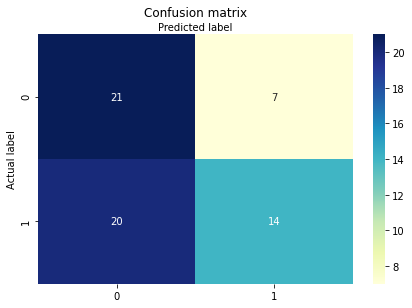

In [ ]:
performance(model, X_test, y_test, X_train, y_train, y_hat, k_fold = True)

In [ ]:
XGBClassifier?

Number of Trees

In [ ]:
'''Number of estimators(number of trees) : is a critical hyperparameter in XGBoost. As greather the number of estimators, the greather the overfitiing'''

def hyper_trees (X_train, y_train, booster = 'gbtree', cv = 5): #add hyperparameter values
  
    train_scores = []
    cv_scores    = []

    # Evaluated values
    estimator_range = range(1, 500, 25)

    # Loop to train a model with each value of n_estimators and extract its training error and k-cross-val

    for n_estimators in estimator_range:
        
        model_trees = XGBClassifier(
                    n_estimators = n_estimators,
                    booster = booster,
                )
        
        # Train error
        model_trees.fit(X_train, y_train)
        predictions = model_trees.predict(X_train)
        acc = metrics.accuracy_score(
                y_true  = y_train,
                y_pred  = predictions,
              )
        train_scores.append(acc)
        
        # Cross validation error
        scores = cross_val_score(
                    estimator = model_trees,
                    X         = X_train,
                    y         = y_train,
                    cv        = 5,
                    n_jobs    = multiprocessing.cpu_count() - 1,
                )
        # The scores of cross_val_score() are added, and then it is switched to positive
        cv_scores.append(-1*scores.mean())
        
    # Graph with the evolution of errors 
    fig, ax = plt.subplots(figsize=(6, 3.84))
    ax.plot(estimator_range, train_scores, label="train scores")
    ax.plot(estimator_range, cv_scores, label="cv scores")
    ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
            marker='o', color = "red", label="min score")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("n_estimators")
    ax.set_title("Evolution of cv-error vs number of trees")
    plt.legend();
    print(f"Optimal value of n_estimators: {estimator_range[np.argmin(cv_scores)]}")

    return

Optimal value of n_estimators: 201


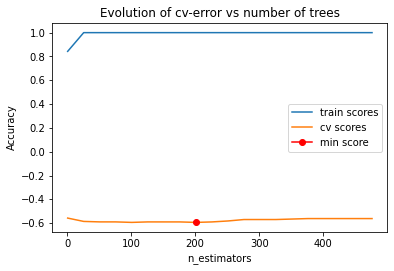

In [ ]:
hyper_trees(X_train, y_train)

Learning rate

In [ ]:
'''It allows how fast learns the model and with it, the risk of overfitting. The number of estimators and learning rate are interdependents hyperparameters, the lower 
   the learning rate, more trees are needed to achieve good results, but the lower the risk of overfitting'''

def hyper_lr(X_train, y_train, booster='gbtree'): 
  
  resultados = {}

  # Evaluated values
  learning_rates = [0.001, 0.01, 0.1]
  n_estimators   = [10, 20, 100, 200, 300, 400, 500, 1000, 2000, 5000]


  # Loop to train the model with each combination of learning_rate and n_estimator and extract its training error and k-cross-val

  for learning_rate in learning_rates:
      train_scores = []
      cv_scores    = []
      
      for n_estimator in n_estimators:
      
          model_lr = XGBClassifier(
                    n_estimators = n_estimator,
                    booster = booster,
                    learning_rate = learning_rate
                )

          # Train error
          model_lr.fit(X_train, y_train)
          predictions = model_lr.predict(X_train)
          acc = metrics.accuracy_score(
                y_true  = y_train,
                y_pred  = predictions,
              )
          train_scores.append(acc)

          # Cross val error
          scores = cross_val_score(
                      estimator = model_lr,
                      X         = X_train,
                      y         = y_train,
                      cv        = 3,
                      n_jobs    = multiprocessing.cpu_count() - 1
                  )
          # The scores of cross_val_score() are added and switched to positive
          cv_scores.append(-1*scores.mean())
          
      resultados[learning_rate] = {'train_scores': train_scores, 'cv_scores': cv_scores}

  # Graph with the evolution of train errors
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3.84))

  for key, value in resultados.items():
      axs[0].plot(n_estimators, value['train_scores'], label=f"Learning rate {key}")
      axs[0].set_ylabel("Accuracy")
      axs[0].set_xlabel("n_estimators")
      axs[0].set_title("Evolution of train error vs learning rate")
      
      axs[1].plot(n_estimators, value['cv_scores'], label=f"Learning rate {key}")
      axs[1].set_ylabel("Accuracy")
      axs[1].set_xlabel("n_estimators")
      axs[1].set_title("Evolution of cv-error vs learning rate")
      plt.legend();

  return

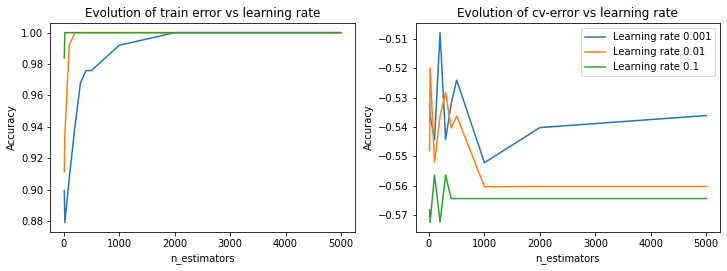

In [ ]:
hyper_lr(X_train, y_train)

In [ ]:
def maxdepth(X_train, y_train, booster='gbtree'): 
  
  train_scores = []
  cv_scores    = []

  # Evaluated values
  max_depths = [1, 3, 5, 10, 20]

  #Loop to train the model wit each max_depth value and extract its training error and k-cross-val

  for max_depth in max_depths:
      
      model = XGBClassifier(
                      n_estimators = 100,
                      booster = booster,
                      learning_rate = 0.001, 
                      max_depth= max_depth
                  )
      
      # Error de train
      model.fit(X_train, y_train)
      pred = model.predict(X_train)
      acc = metrics.accuracy_score(
                y_true  = y_train,
                y_pred  = pred,
              )
      train_scores.append(acc)
      
      # Cross validation error
      scores = cross_val_score(
                  estimator = model,
                  X         = X_train,
                  y         = y_train,
                  scoring   = 'f1',
                  cv        = 5,
                  n_jobs    = multiprocessing.cpu_count() - 1
              )

      cv_scores.append(-1*scores.mean())
      
  # Error graph
  fig, ax = plt.subplots(figsize=(6, 3.84))
  ax.plot(max_depths, train_scores, label="train scores")
  ax.plot(max_depths, cv_scores, label="cv scores")
  ax.plot(max_depths[np.argmin(cv_scores)], min(cv_scores),
          marker='o', color = "red", label="min score")
  ax.set_ylabel("root_mean_squared_error")
  ax.set_xlabel("max_depth")
  ax.set_title("Evolución del cv-error vs profundidad árboles")
  plt.legend();
  print(f"Valor óptimo de max_depth: {max_depths[np.argmin(cv_scores)]}")

Valor óptimo de max_depth: 3


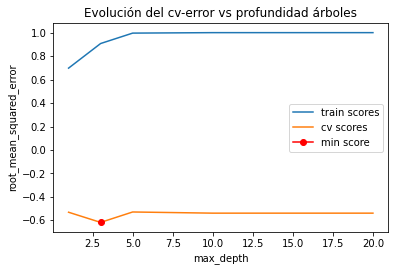

In [ ]:
maxdepth(X_train, y_train)

In [ ]:
#Hyperparameters to tune
param_grid = {'booster'  : ['gbtree', 'gblinear', 'dart'],
              'max_depth'     : [0, 1, 3, 5, 10, 20],
              'subsample'     : [0.5, 1],
              'learning_rate' : [0.001, 0.01, 0.1]
             }

# grid search with cross validation


grid = GridSearchCV(
        estimator  = XGBClassifier(
                        n_estimators        = 1000, 
                        random_state        = 123,
                        # Activación de la parada temprana
                        validation_fraction = 0.1,
                        n_iter_no_change    = 5,
                        tol                 = 0.0001
                    ),
        param_grid = param_grid,
        scoring    = 'f1',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Results
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


,param_booster,param_learning_rate,param_max_depth,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
5,gbtree,0.001,3,1,0.557067,0.074893,0.993928,0.00481
77,dart,0.001,3,1,0.557067,0.074893,0.993928,0.00481
106,dart,0.1,20,0.5,0.556626,0.088854,1.000000,0.00000
104,dart,0.1,10,0.5,0.556626,0.088854,1.000000,0.00000


In [ ]:
print("Best hyperparameters found: ", 
print(grid.best_params_, ":", grid.best_score_, grid.scoring))

In [ ]:
print(f"Number of model trees: {grid.best_estimator_.n_estimators_}")

In [ ]:
#Once the hyperparameters have been identify, the model is retrained providing the optimal values in their args
final_model = grid.best_estimator_
predic = final_model.predict(X = X_test)
f1= f1_score(
        y_true  = y_test,
        y_pred  = predic,
       )
print(f"The (f1) score is: {f1}")